# Implement a custom Autoencoder with Koopman layer

This code is to load a model (only)

## Version Control

To Do:
1) Account for trailing batch - Make robust (fixed issue by reshaping input data)
4) Validation data has different batch size. Address when HP training

## Setup

In [1]:
import tensorflow as tf
import matplotlib as mpl
from matplotlib import pyplot as plt
from tensorflow import keras

import  numpy as np
import pandas as pd


import matplotlib.colors as mcol
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.animation as animation


import time 
import os

import glob

In [2]:
plt.rcParams['figure.figsize'] = [9, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
#from google.colab import drive
#drive.mount('/gdrive')

Comment out if don't need

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


# Load the Model

In [5]:
new_model = tf.keras.models.load_model('checkpoints/champ_Trained_Model', compile=False)
new_model.summary()

Model: "Koopman_AE_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_model (EncoderModel  multiple                 99968     
 )                                                               
                                                                 
 koopman__model (Koopman_Mod  multiple                 16384     
 el)                                                             
                                                                 
 decoder_model (DecoderModel  multiple                 66822     
 )                                                               
                                                                 
Total params: 183,174
Trainable params: 183,174
Non-trainable params: 0
_________________________________________________________________


## Load data

### Read Sim Data Functions

In [6]:
def preprocessSimData(df, desiredStates:list, initialIndex:int=300, finalIndex:int=812):
    '''
    Preprocess text file (fixing formatting issue in data as well) while returning a dataframe object with the desired states selected

    Parameters:
    -----------
    df: dataFrame
        Panda dataframe that is read from one of the recorded simulation .txt files
    desiredStates: list
        List of desired states to return as a panda dataframe object in sequential order

    Return:
    ----------
    stateMatrix: dataFrame
        State matrix with desired states
    '''



    # Fix formatting Variables
    falseList = ['time_lf_hip_joint_position', 'lf_lower_leg_joint_position', 'lf_upper_leg_joint_position', 'lh_hip_joint_position', 'lh_lower_leg_joint_position', 'lh_upper_leg_joint_position',
                'rf_hip_joint_position', 'rf_lower_leg_joint_position', 'rf_upper_leg_joint_position', 'rh_hip_joint_position', 'rh_lower_leg_joint_position', 'rh_upper_leg_joint_position',
                'lf_hip_joint_vel', 'lf_lower_leg_joint_vel', 'lf_upper_leg_joint_vel', 'lh_hip_joint_vel', 'lh_lower_leg_joint_vel', 'lh_upper_leg_joint_vel',
                'rf_hip_joint_vel', 'rf_lower_leg_joint_vel', 'rf_upper_leg_joint_vel', 'rh_hip_joint_vel', 'rh_lower_leg_joint_vel', 'rh_upper_leg_joint_vel',
                'lf_hip_joint_effort', 'lf_lower_leg_joint_effort', 'lf_upper_leg_joint_effort', 'lh_hip_joint_effort', 'lh_lower_leg_joint_effort', 'lh_upper_leg_joint_effort',
                'rf_hip_joint_effort', 'rf_lower_leg_joint_effort', 'rf_upper_leg_joint_effort', 'rh_hip_joint_effort', 'rh_lower_leg_joint_effort', 'rh_upper_leg_joint_effort', 'nan']
    df.columns = falseList
    df['time_lf_hip_joint_position'] = df.time_lf_hip_joint_position.str[0:8] + ' ' + df.time_lf_hip_joint_position.str[8:]


    # Data and State Name List
    data = df.values # np array of data values
    namesList = ['time', 'lf_hip_joint_position', 'lf_lower_leg_joint_position', 'lf_upper_leg_joint_position', 'lh_hip_joint_position', 'lh_lower_leg_joint_position', 'lh_upper_leg_joint_position',
                'rf_hip_joint_position', 'rf_lower_leg_joint_position', 'rf_upper_leg_joint_position', 'rh_hip_joint_position', 'rh_lower_leg_joint_position', 'rh_upper_leg_joint_position',
                'lf_hip_joint_vel', 'lf_lower_leg_joint_vel', 'lf_upper_leg_joint_vel', 'lh_hip_joint_vel', 'lh_lower_leg_joint_vel', 'lh_upper_leg_joint_vel',
                'rf_hip_joint_vel', 'rf_lower_leg_joint_vel', 'rf_upper_leg_joint_vel', 'rh_hip_joint_vel', 'rh_lower_leg_joint_vel', 'rh_upper_leg_joint_vel',
                'lf_hip_joint_effort', 'lf_lower_leg_joint_effort', 'lf_upper_leg_joint_effort', 'lh_hip_joint_effort', 'lh_lower_leg_joint_effort', 'lh_upper_leg_joint_effort',
                'rf_hip_joint_effort', 'rf_lower_leg_joint_effort', 'rf_upper_leg_joint_effort', 'rh_hip_joint_effort', 'rh_lower_leg_joint_effort', 'rh_upper_leg_joint_effort']

    dictStates = {}
    staticCounter = 0 # Variable to account for formatting issue
    for index in range(len(namesList)-1):
        if index == 0 and staticCounter == 0: # Condition for formatting issue of collected data
            for j in range(len(data[:,index])): # Looping through all elements in column 0 and converting to float
                if j == 0: # Initialize array
                    array1 = float(data[j,index][0:8])
                    #print(array1)
                    array2 = float(data[j,index][8:])
                    #print(array2)
                else:
                    array1 = np.vstack((array1,float(data[j,index][0:8])))
                    array2 = np.vstack((array2,float(data[j,index][8:])))
            dictStates[namesList[index]] = np.squeeze(array1[initialIndex:finalIndex])
            dictStates[namesList[index+1]] = np.squeeze(array2[initialIndex:finalIndex])        
        else:
            dictStates[namesList[index+1]] = data[initialIndex:finalIndex,index]
    for counter, names in enumerate(desiredStates):
        if counter == 0:
            stateMatrix = np.reshape(dictStates[names], (-1,1))
        else:
            stateMatrix = np.hstack((stateMatrix, np.reshape(dictStates[names], (-1,1))))
    return pd.DataFrame(stateMatrix, columns = desiredStates)



def preprocessFile(fileNames:list, initialIndex:int, finalIndex:int, desiredStates:list):
    '''
    Given fileNames to read, reads the file(s) and returns all data concatenated in a panda dataframe framework

    Paramaters:
    -----------
    fileNamess:list
        List of filenames to read and concatenate data together
    intialIndex: int
        Index to start reading each file's data from
    finalIndex: int
        Index to stop reading each file's data from
    desiredStates:list
        List of states to read
    
    Return:
    ----------
    totalData: dataFrame
        Returns data of all filenames with given states in one panda dataframe
    '''

    filePaths = []
    for i in fileNames:
        filePaths.append(glob.glob(i))
    #print(filePaths)


    dataFrameList = []
    for i in filePaths:
        for j in i:
            df = pd.read_csv(j, sep= " ", header=None)
            dataFrameList.append(preprocessSimData(df, desiredStates, initialIndex=initialIndex, finalIndex=finalIndex)) # 712-200 = 512 --> 512-1 is 512 indices (i.e. [0, 511])

    totalData = pd.concat(dataFrameList)
    return totalData

### Read full data

In [7]:
# List of states
namesList = ['time', 'lf_hip_joint_position', 'lf_lower_leg_joint_position', 'lf_upper_leg_joint_position', 'lh_hip_joint_position', 'lh_lower_leg_joint_position', 'lh_upper_leg_joint_position',
                'rf_hip_joint_position', 'rf_lower_leg_joint_position', 'rf_upper_leg_joint_position', 'rh_hip_joint_position', 'rh_lower_leg_joint_position', 'rh_upper_leg_joint_position',
                'lf_hip_joint_vel', 'lf_lower_leg_joint_vel', 'lf_upper_leg_joint_vel', 'lh_hip_joint_vel', 'lh_lower_leg_joint_vel', 'lh_upper_leg_joint_vel',
                'rf_hip_joint_vel', 'rf_lower_leg_joint_vel', 'rf_upper_leg_joint_vel', 'rh_hip_joint_vel', 'rh_lower_leg_joint_vel', 'rh_upper_leg_joint_vel',
                'lf_hip_joint_effort', 'lf_lower_leg_joint_effort', 'lf_upper_leg_joint_effort', 'lh_hip_joint_effort', 'lh_lower_leg_joint_effort', 'lh_upper_leg_joint_effort',
                'rf_hip_joint_effort', 'rf_lower_leg_joint_effort', 'rf_upper_leg_joint_effort', 'rh_hip_joint_effort', 'rh_lower_leg_joint_effort', 'rh_upper_leg_joint_effort']


In [8]:
desiredStates = ['lf_hip_joint_position', 'lf_hip_joint_vel', 'lf_lower_leg_joint_position', 
                'lf_lower_leg_joint_vel', 'lf_hip_joint_effort', 'lf_lower_leg_joint_effort']

input_dim = len(desiredStates)
output_dim = input_dim

trajLength = 2**6 # Length of each trajectory in the dataset

filePath = "simData"
fileNames = [filePath + '/empty_world_ground_2/joint_state_test_emptyWorld_forward_0.5*']


numTraj = 256 # Total number of trajectories in the dataset (train)
numTraj_val = 32
numTraj_test = 32
batch_size = int(2**8) # Number of snapshots in each batch
numTraj_batch = int(batch_size/trajLength)
numTraj_batch = int(batch_size/trajLength)

initialIndex, finalIndex= 400, 400+trajLength*(numTraj+numTraj_val+numTraj_test)

num_batches_train = int(trajLength*numTraj/batch_size) ## num_batches = trajLength*numTraj/batch_size 
num_batches_val = int(trajLength*numTraj_val/batch_size)


In [9]:
doggoFrame = preprocessFile(fileNames,initialIndex,finalIndex, desiredStates)
doggoFrame.head(5)

,lf_hip_joint_position,lf_hip_joint_vel,lf_lower_leg_joint_position,lf_lower_leg_joint_vel,lf_hip_joint_effort,lf_lower_leg_joint_effort
0,0.0013,3.6865,-1.4667,19.5187,4.1101,25.0
1,-0.0027,-3.9149,-1.5198,-30.1504,-3.6843,-24.6202
2,0.0009,3.4271,-1.5245,15.1851,3.5978,21.3211
3,-0.0012,-2.4308,-1.5679,-19.652,-2.8346,-15.4825
4,0.0009,1.4415,-1.584,2.1823,1.589,8.4289


In [10]:
print("Datapoints: ", len(doggoFrame.index))

Datapoints:  20480


In [11]:
doggo_train = doggoFrame.values[:numTraj*trajLength,:]
doggo_validation = doggoFrame.values[numTraj*trajLength:(numTraj+numTraj_val)*trajLength,:]
doggo_test = doggoFrame.values[(numTraj+numTraj_val)*trajLength:(numTraj+numTraj_val+numTraj_test)*trajLength,:]

doggo_train = np.asarray(doggo_train).astype('float32')
doggo_test = np.asarray(doggo_test).astype('float32')
doggo_validation = np.asarray(doggo_validation).astype('float32')

In [12]:
print("Size of doggo_train:", len(doggo_train))
print("Size of doggo_validation:", len(doggo_validation))
print("Size of doggo_test:", len(doggo_test))

Size of doggo_train: 16384
Size of doggo_validation: 2048
Size of doggo_test: 2048


### Make into dataset

In [13]:
# Normalize the data
min_val = tf.reduce_min(doggo_train)
max_val = tf.reduce_max(doggo_train)

#doggo_train = (doggo_train - min_val) / (max_val - min_val)
#doggo_validation = (doggo_validation - min_val) / (max_val - min_val)
#doggo_test = (doggo_test - min_val) / (max_val - min_val)

train_data = tf.cast(doggo_train[0:batch_size*num_batches_train], tf.float32)
validation_data = tf.cast(doggo_validation[0:batch_size*num_batches_val], tf.float32)
validation_data = tf.data.Dataset.from_tensor_slices((validation_data, validation_data)).batch(batch_size)
test_data = tf.cast(doggo_test, tf.float32)

In [14]:
x_train = train_data
y_train = train_data

# Animate Setup

In [15]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)

In [16]:
mp4FilePath = 'mp4/'
try:
    os.mkdir(mp4FilePath)
except OSError as exc:
    print(exc.errno)

17


In [17]:
def animateStatesError(middleLine, boundLine, desiredStates:list, titlePrefix, mp4FilePath = 'mp4/', ifBoundLine=True, xlim=[0,128], ylim=[0,1], numFrames=128):
    '''
    Given the average trajectory error, standard deviation error, and desired states,
    animate the trajectory with given legend into a mp4 under the mp4 folder

    Parameters:
    -----------
    middleLine: ndarray
        Trajectory of the middle line (nxlen(desiredStates))
    boundLine: ndarray
        Trajectory of the bound for upper and lower bound (+/- stdDev)
    desiredStates: list
        List of the desired states
    titlePrefix: str
        Prefix title to save into mp4FilePath
    mp4FilePath: str
        Directory path to save mp4
    ifBoundLine: Boolean
        ifBoundLine is true, graphs with bounded fill between lines, else just graphs middle line
    xlim: list
        Limit of plot axis in x direction for animating
    ylim: list
        Limit of plot axis in y direction for animating


    Return:
    ---------
    None
    '''
    for j in range(np.shape(middleLine)[1]):
        # Set up figure, axis, and plot element want to animate
        fig, ax = plt.subplots(figsize=(10,6))
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        line, = ax.plot([],[], lw=2, label=desiredStates[j].replace("_", " "))
        plt.style.use('default')
        plt.legend()
        plt.tight_layout()

        # Initialize function: plot the background of each frame
        def init():
            line.set_data([], [])

            return line,


        # animation function called sequentially
        def animate(i, j):
            x = range(len(middleLine[0:i,j]))
            data = middleLine[0:i,j] #select data range
            line.set_data(x,data)
            line.set_color('#1f77b4')
        
            if ifBoundLine:
                p = plt.fill_between(range(len(boundLine[0:i,j])), middleLine[0:i,j]-boundLine[0:i,j], 
                                middleLine[0:i,j]+boundLine[0:i,j], facecolor='lightsteelblue')
                return line, p,
            else:
                return line,

        anim = animation.FuncAnimation(fig, animate, init_func=init, frames=numFrames,
                                    interval=10, repeat=True, blit=True, fargs=(j,))

        anim.save(mp4FilePath+titlePrefix+'_'+ desiredStates[j]+'.mp4', writer=writer, dpi=300)
        plt.close()

In [18]:
def animateStates(predictedLine, gTruthLine, label1, label2, desiredStates:list, titlePrefix, mp4FilePath = 'mp4/', ifGTruthLine=True, xlim=[0,128], ylim=[0,1],numFrames=128):
    '''
    Given the predicted and ground truth trajectory, as well as desired states,
    animate the trajectory with given legend into a mp4 under the mp4FilePath folder

    Parameters:
    -----------
    predictedLine: ndarray
        Trajectory of the predicted line (nxlen(desiredStates))
    gTruthLine: ndarray
        Trajectory of the ground truth line (+/- stdDev)
    label1: str
        Label for predicted line (suffix)
    label2: str
        Label for ground truth line (suffix)
    desiredStates: list
        List of the desired states
    titlePrefix: str
        Prefix title to save into mp4FilePath
    mp4FilePath: str
        Directory path to save mp4
    ifBoundLine: Boolean
        ifBoundLine is true, graphs with bounded fill between lines, else just graphs middle line
    xlim: list
        Limit of plot axis in x direction
    ylim: list
        Limit of axis in y direction
        
    Return:
    ---------
    None
    '''
    for j in range(np.shape(predictedLine)[1]):
        # Set up figure, axis, and plot element want to animate
        fig, ax = plt.subplots(figsize=(10,6))
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        line, = ax.plot([],[], lw=2, label=desiredStates[j].replace("_", " ") + " " + label1)
        line.set_color('C1')
        plt.setp(line, linestyle='--')
        if ifGTruthLine:
            line2, = ax.plot([],[], lw=2, label=desiredStates[j].replace("_", " ") + " " + label2)
            line2.set_color('C0')
            #plt.setp(line2, linestyle='--')
        
        plt.style.use('default')
        plt.legend(loc='upper left')
        plt.tight_layout()

        # Initialize function: plot the background of each frame
        def init():
            line.set_data([], [])
            if ifGTruthLine:
                line2.set_data([],[])
            return line,


        # animation function called sequentially
        def animate(i, j):
            x = range(len(predictedLine[0:i,j]))
            data = predictedLine[0:i,j] #select data range
            line.set_data(x,data)
            if ifGTruthLine:
                line2.set_data(x, gTruthLine[0:i,j])
          
            return line,

        anim = animation.FuncAnimation(fig, animate, init_func=init, frames=numFrames,
                                    interval=10, repeat=True, blit=True, fargs=(j,))

        anim.save(mp4FilePath+titlePrefix+'_'+ desiredStates[j]+'.mp4', writer=writer, dpi=300)
        plt.close()

# Load data into model

In [19]:
input = x_train
new_out1, new_out2, new_out3 = new_model(input)

# Graphing Error Section

#### Average Error Function

In [20]:
def preProcessForAvg(input, numTraj_batch, trajLength, num_batches, desiredStates, model):
    '''
    Given input, the number of trajectory in each batch, and the trajector length, outputs
    batch data concatenated vertically on top of one another by calling the Koopman AE class

    Parameters:
    -----------
    input: Tensor
        Input data to reshape into outputs
    numTraj_batch: int
        Number of trajectory per batch
    trajLength: int
        Number of snapshots in a trajectory
    desiredStates: list
        List of states
    model: Koopman AE keras model
        Koopman AE model to propagate data

    Return:
    ----------
    x1_all: tensor
        Copy of input (No need for change) (Ground Truth)
    x2_all: tensor
        Concatenated tensor of 1 time shifted data for all batches (Ground Truth)
    x3_all: tensor
        Concatenated tensor of 1 time step shifted data for all batches (x2_all=x3_all) (Ground Truth)
    out1_all: tensor
        Reconstruction of input (parameter) using the Koopman AE class
    out2_all: tensor
        Predicted output from Koopman model of concatenated tensors of 1 time shifted data for all batches
    out3_all: tensor
        Predicted n time step output from Koopman model of concatenated tensors data for all batches
    '''
    
    x2_all = []
    out1_all = []
    out2_all = []
    out3_all = []
    x = input

    for i in range(num_batches):
        x2 = []
        for j in range(numTraj_batch):
            x2.append(x[(i*numTraj_batch+j)*trajLength+1:(i*numTraj_batch+j+1)*trajLength])
        x2 = tf.reshape(x2, [-1, x.shape[-1]]) # Shifted input for a batch
        x2_all.append(x2)
        
        x_input = x[i*numTraj_batch*trajLength:(i+1)*numTraj_batch*trajLength]
        out1, out2, out3 = model(x_input)
        out1_all.append(out1)
        out2_all.append(out2)
        out3_all.append(out3)
        
    x1_all = x
    x2_all = tf.reshape(x2_all,(-1,len(desiredStates)))
    x3_all = x2_all
    out1_all = tf.reshape(out1_all,(-1,len(desiredStates)))
    out2_all = tf.reshape(out2_all,(-1,len(desiredStates)))
    out3_all = tf.reshape(out3_all,(-1,len(desiredStates)))


    '''
    print(tf.shape(x2_all))
    print(tf.shape(out1_all))
    print(tf.shape(out2_all))
    print(tf.shape(out3_all))
    '''

    return x1_all, x2_all, x3_all, out1_all, out2_all, out3_all

In [21]:
def avgTrajError(gTruth, predicted, trajLength, numTraj):
    '''
    Get the average trajectory error with min and max values (Maybe std dev better)

    Parameters:
    -----------
    gTruth: tensor or ndarray
        Ground Truth matrix
    predicted: tensor or ndarray
        Predicted matrix
    trajLength: int
        Length of trajectory
    numTraj: int
        Number of trajectory (total?)
    

    Return:
    ----------
    avgErrorList: list
        List of average errors of all trajectories (each index is the avg error of the states at a point of time along the trajectory)
    
    errorList: list
        List of error of all states and trajectory
    '''
    errorList = []
    avgErrorList = []
    numStates = len(gTruth[0,:])
    for i in range(numTraj):
        '''
        print("Gtruth")
        print(np.array(gTruth)[i*trajLength:(i+1)*trajLength,:])
        print("Predicted")
        print(np.array(predicted[i*trajLength:(i+1)*trajLength,:]))
        print("---Loop---")
        '''
        errorList.append(np.array(gTruth)[i*trajLength:(i+1)*trajLength,:] - np.array(predicted[i*trajLength:(i+1)*trajLength,:]))
    
    #print("Error List")
    #print(np.shape(errorList[0]))
    
    for j in range(trajLength):
        #print("Length of Traj %d"% j)
        for k in range(numTraj):
            #print("Traj: %d"% k)
            if k == 0:
                avgErrorList.append(errorList[k][j,:])
            else:
                #print(avgErrorList[j])
                avgErrorList[j] = (k*avgErrorList[j]+errorList[k][j,:])/(k+1) # Recursive average formula
    return avgErrorList, errorList
        
    

#### Preprocess Error Graph Data

In [22]:
x1_all,x2_all,x3_all, out1_all,out2_all,out3_all = preProcessForAvg(x_train,numTraj_batch, trajLength, num_batches_train, desiredStates, new_model)
avgTrajErrorList, errorList = avgTrajError(x3_all, out3_all, trajLength-1, numTraj)

In [23]:
saveErrorPath = 'errorGraph/'
try:
    os.mkdir(saveErrorPath)
except OSError as exc:
    print(exc.errno)

17


#### Error Graphs

##### Reconstruction Error

In [24]:
avgTrajErrorList, errorList = avgTrajError(x1_all, out1_all, trajLength, numTraj)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

In [25]:
for i in range(len(desiredStates)):
    plt.figure()
    plt.style.use('default')
    plt.plot(avgTrajErrorArray[:,i])
    plt.fill_between(range(len(errorStdDevArray[:,i])), avgTrajErrorArray[:750,i]-errorStdDevArray[:750,i], avgTrajErrorArray[:750,i]+errorStdDevArray[:750,i],alpha = 0.3)
    title=desiredStates[i]
    plt.title(title)
    plt.ylabel("Reconstruction Error")
    plt.xlabel("Time Step")
    plt.ylim((0,1))
    plt.savefig(saveErrorPath+'recon_error_'+title+'.png', dpi=300)
    plt.close()

##### Forward Time Shift Prediction Error

##### Linearity Prediction Error

In [26]:
avgTrajErrorList, errorList = avgTrajError(x2_all, out2_all, trajLength-1, numTraj)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

In [27]:
for i in range(len(desiredStates)):
    plt.figure()
    plt.style.use('default')
    plt.plot(avgTrajErrorArray[:,i])
    plt.fill_between(range(len(errorStdDevArray[:750,i])), avgTrajErrorArray[:750,i]-errorStdDevArray[:750,i], avgTrajErrorArray[:750,i]+errorStdDevArray[:750,i],alpha = 0.3)
    title=desiredStates[i]
    plt.title(title)
    plt.ylabel("Forward Time Shift Prediction Error")
    plt.xlabel("Time Step")
    plt.ylim((0,1))
    plt.savefig(saveErrorPath+'ftimeShift_error_'+title+'.png', dpi=300)
    plt.close()

#### Reconstruction/Forward Time Shift Prediction/Linear Prediction Graph

In [28]:
saveOutputPath = 'outputGraph/'
try:
    os.mkdir(saveOutputPath)
except OSError as exc:
    print(exc.errno)

17


In [29]:
for i in range(len(desiredStates)):
    plt.figure(figsize=(8,4))
    plt.style.use('default')
    plt.plot(x1_all[:750,i])
    plt.plot(out1_all[:750,i],'--',label="")
    plt.ylabel("Reconstruction")
    plt.xlabel("Time Step")
    title = desiredStates[i]
    plt.title(title)
    plt.ylim((0,1))
    plt.savefig(saveOutputPath+'recon_'+title+'.png', dpi=300)
    plt.close()

In [30]:
for i in range(len(desiredStates)):
    plt.figure(figsize=(8,4))
    plt.style.use('default')
    plt.plot(x2_all[:750,i])
    plt.plot(out2_all[:750,i],'--',label="")
    plt.ylabel("Forward Time Shift Prediction")
    plt.xlabel("Time Step")
    title = desiredStates[i]
    plt.title(title)
    plt.ylim((0,1))
    plt.savefig(saveOutputPath+'ftimeShiftPred_'+title+'.png', dpi=300)
    plt.close()

In [31]:
for i in range(len(desiredStates)):
    plt.figure(figsize=(8,4))
    plt.style.use('default')
    plt.plot(x3_all[:750,i])
    plt.plot(out3_all[:750,i],'--',label="")
    plt.ylabel("Linear Prediction")
    plt.xlabel("Time Step")
    title = desiredStates[i]
    plt.title(title)
    plt.ylim((0,1))
    plt.savefig(saveOutputPath+'linPred_'+title+'.png', dpi=300)
    plt.close()

In [32]:
x = input
x2 = []
for i in range(numTraj_batch):
    x2.append(x[i*trajLength+1:(i+1)*trajLength])
x2 = tf.reshape(x2, [-1, x.shape[-1]]) # Shifted input

In [33]:
avgTrajErrorList, errorList = avgTrajError(x3_all, out3_all, trajLength-1, numTraj)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

In [34]:
for i in range(len(desiredStates)):
    plt.figure()
    plt.style.use('default')
    plt.plot(avgTrajErrorArray[:,i])
    plt.fill_between(range(len(errorStdDevArray[:750,i])), avgTrajErrorArray[:750,i]-errorStdDevArray[:750,i], avgTrajErrorArray[:750,i]+errorStdDevArray[:750,i],alpha = 0.3)
    title=desiredStates[i]
    plt.title(title)
    plt.ylabel("Linear Prediction Error")
    plt.xlabel("Time Step")
    plt.ylim((0,1))
    plt.savefig(saveErrorPath+'linPred_'+title+'.png', dpi=300)
    plt.close()

# Animate

Error

In [35]:
# Reconstruction Error
avgTrajErrorList, errorList = avgTrajError(x1_all, out1_all, trajLength, numTraj)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

animateStatesError(avgTrajErrorArray, errorStdDevArray, desiredStates, 'train_recon_error')

# Forward Time Shift Prediction Error
avgTrajErrorList, errorList = avgTrajError(x2_all, out2_all, trajLength-1, numTraj)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

animateStatesError(avgTrajErrorArray, errorStdDevArray, desiredStates, 'train_fTimeShiftPred_error')

# Linear Prediction Error
avgTrajErrorList, errorList = avgTrajError(x3_all, out3_all, trajLength-1, numTraj)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

animateStatesError(avgTrajErrorArray, errorStdDevArray, desiredStates, 'train_linPred_error')

Trajectory

In [36]:
animateStates(out1_all,x1_all,'Reconstruction','Truth',  desiredStates, 'train_traj_recon')
animateStates(out2_all,x2_all,'Forward Time Shift','Truth', desiredStates, 'train_traj_FTimeShiftPred')
animateStates(out3_all,x3_all,'Lin Pred','Truth', desiredStates, 'train_traj_linPred')

# Test Graphs

## Prediction Graphs

In [37]:
saveTestOutputPath = 'testOutputGraph/'
try:
    os.mkdir(saveTestOutputPath)
except OSError as exc:
    print(exc.errno)

17


In [38]:
input = doggo_validation
new_out1, new_out2, new_out3 = new_model(input)

In [39]:
nx1_all,nx2_all,nx3_all,nout1_all,nout2_all,nout3_all = preProcessForAvg(input,numTraj_batch,trajLength,num_batches_val,desiredStates, new_model)

In [40]:
for i in range(len(desiredStates)):
    plt.figure(figsize=(8,4))
    plt.style.use('default')
    plt.plot(nx1_all[:500,i])
    plt.plot(nout1_all[:500,i],'--',label="")
    plt.ylabel("Reconstruction")
    plt.xlabel("Time Step")
    title = desiredStates[i]
    plt.title(title)
    #plt.ylim((0,1))
    plt.savefig(saveTestOutputPath+'test_recon_'+title+'.png', dpi=300)
    plt.close()

In [41]:
for i in range(len(desiredStates)):
    plt.figure(figsize=(8,4))
    plt.style.use('default')
    plt.plot(nx2_all[:500,i])
    plt.plot(nout2_all[:500,i],'--',label="")
    plt.ylabel("Forward Time Shift Prediction")
    plt.xlabel("Time Step")
    title = desiredStates[i]
    plt.title(title)
    #plt.ylim((0,1))
    plt.savefig(saveTestOutputPath+'test_fTimeShift_'+title+'.png', dpi=300)
    plt.close()

In [42]:
for i in range(len(desiredStates)):
    plt.figure(figsize=(8,4))
    plt.style.use('default')
    plt.plot(nx3_all[:500,i])
    plt.plot(nout3_all[:500,i],'--',label="")
    plt.ylabel("Linear Prediction")
    plt.xlabel("Time Step")
    title = desiredStates[i]
    plt.title(title)
    #plt.ylim((0,1))
    plt.savefig(saveTestOutputPath+'test_linPred_'+title+'.png', dpi=300)
    plt.close()

## Error Graphs

In [43]:
avgTrajErrorList, errorList = avgTrajError(nx1_all, nout1_all, trajLength, numTraj_test)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

for i in range(len(desiredStates)):
    plt.figure(figsize=(8,4))
    plt.style.use('default')
    plt.plot(avgTrajErrorArray[:500,i])
    plt.fill_between(range(len(errorStdDevArray[:500,i])), avgTrajErrorArray[:500,i]-errorStdDevArray[:500,i],
                    avgTrajErrorArray[:500,i]+errorStdDevArray[:500,i], facecolor='lightsteelblue')
    title=desiredStates[i]
    plt.title(title)
    plt.ylabel("Reconstruction Error")
    plt.xlabel("Time Step")
    #plt.ylim((-0.25,0.25))
    plt.tight_layout()
    plt.savefig(saveTestOutputPath+'test_recon_error_'+title+'.png', dpi=300)
    plt.close()

In [44]:
avgTrajErrorList, errorList = avgTrajError(nx2_all, nout2_all, trajLength-1, numTraj_test)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

for i in range(len(desiredStates)):
    plt.figure(figsize=(8,4))
    plt.style.use('default')
    plt.plot(avgTrajErrorArray[:,i])
    plt.fill_between(range(len(errorStdDevArray[:500,i])), avgTrajErrorArray[:500,i]-errorStdDevArray[:500,i],
                    avgTrajErrorArray[:500,i]+errorStdDevArray[:500,i], facecolor='lightsteelblue')
    title=desiredStates[i]
    plt.title(title)
    plt.ylabel("Forward Time Shift Error")
    plt.xlabel("Time Step")
    #plt.ylim((-0.003,0.003))
    plt.tight_layout()
    plt.savefig(saveTestOutputPath+'test_FTimeShift_error_'+title+'.png', dpi=300)
    plt.close()

In [45]:
avgTrajErrorList, errorList = avgTrajError(nx3_all, nout3_all, trajLength-1, numTraj_test)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

for i in range(len(desiredStates)):
    plt.figure(figsize=(8,4))
    plt.style.use('default')
    plt.plot(avgTrajErrorArray[:500,i])
    plt.fill_between(range(len(errorStdDevArray[:500,i])), avgTrajErrorArray[:500,i]-errorStdDevArray[:500,i],
                    avgTrajErrorArray[:500,i]+errorStdDevArray[:500,i], facecolor='lightsteelblue')
    title=desiredStates[i]
    plt.title(title)
    plt.ylabel("Linear Prediction Error")
    plt.xlabel("Time Step")
    #plt.ylim((-0.003,0.003))
    plt.tight_layout()
    plt.savefig(saveTestOutputPath+'test_LinPred_error_'+title+'.png', dpi=300)
    plt.close()

## Phase Portrait

In [46]:
plt.plot(nx1_all[:,0], nx1_all[:,1], label="Ground Truth")
plt.plot(nout1_all[:,0], nout1_all[:,1], linestyle='--',label="Reconstruction")
title = 'Phase Reconstruction'
plt.title(title)
plt.xlabel("Hip Joint Position")
plt.ylabel("Hip Joint Velocity")
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig(saveTestOutputPath+'test_' +title+'.png', dpi=300)
plt.close()


plt.plot(nx2_all[:,0], nx2_all[:,1], label="Ground Truth")
plt.plot(nout1_all[:,0], nout1_all[:,1], linestyle='--',label="Forward Time Shift")
title = "Forward Time Shift"
plt.title(title)
plt.xlabel("Hip Joint Position")
plt.ylabel("Hip Joint Velocity")
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig(saveTestOutputPath+'test_'+title+'.png', dpi=300)
plt.close()


plt.plot(nx3_all[:,0], nx3_all[:,1], label="Ground Truth")
plt.plot(nout3_all[:,0], nout3_all[:,1], linestyle='--',label="Linear Prediction")
title = "Forward Time Shift"
plt.title(title)
plt.xlabel("Hip Joint Position")
plt.ylabel("Hip Joint Velocity")
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig(saveTestOutputPath+'test_'+title+'.png', dpi=300)
plt.close()

## Koopman Spectrum

Koopman Eigenvalues

In [47]:
w,v = np.linalg.eig(new_model.koopman.get_weights())
fig = plt.figure(figsize=(5.5,5))
ax = fig.add_subplot(1,1,1)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None')
ax.add_patch(circ)
plt.scatter(w.real.squeeze(), w.imag.squeeze())
title = "Koopman Eigenvalues - Empty Ground"
plt.title(title)
plt.savefig(saveTestOutputPath+'test_'+title+'.png', dpi=300)
plt.close()

Koopman eigenfunctions

In [48]:
# take theta gamma from mesh grid
x1 = tf.squeeze(tf.linspace(-1,1,256))
x4 = tf.squeeze(tf.linspace(-1,1,256))
#print("x1 shape", x1.shape)
x1, x4 = tf.meshgrid(x1, x4)
X1 = tf.transpose(tf.reshape(tf.concat([[x1],[x4]],axis=0),[2,-1]))
#print("X1 shape: ", X1.shape)

# take theta dot and gamma got from traj dataFrameList
sample = train_data[0:batch_size,:]
x2 = sample[:,1]
x5 = sample[:,3]
x2 = tf.squeeze(tf.linspace(-1,1,256))
x5 = tf.squeeze(tf.linspace(-1,1,256))
x2, x5 = tf.meshgrid(x2, x5)
#print("x2 shape: ", x2.shape)

x3 = tf.squeeze(tf.linspace(-1,1,256))
x6 = tf.squeeze(tf.linspace(-1,1,256))
x3, x6 = tf.meshgrid(x3, x6)
X = tf.transpose(tf.reshape(tf.concat([[x1],[x2],[x3],[x4],[x5],[x6]],axis=0),[6,-1]))
X = x_train
#print("X shape: ", X.shape)

In [49]:
print(np.shape(x_train))
print(np.shape(X))

(16384, 6)
(16384, 6)


In [50]:
K = new_model.koopman.get_weights()
K = tf.constant(K, dtype=tf.float32)
eig_vals, right_eig_vectors = tf.linalg.eig(K)
W = tf.transpose(tf.linalg.inv(right_eig_vectors))
Z = new_model.enc(X)
complex_vals = tf.math.imag(tf.zeros(tf.shape(Z)))
Z = tf.complex(Z, complex_vals)
Psi = tf.linalg.matmul(Z, W)
Psi_mag = tf.math.abs(Psi)
Psi_ang = tf.math.angle(Psi)

In [51]:
# Look for dominant eigenvalue index
print(tf.math.abs(eig_vals))

tf.Tensor(
[[0.02492656 0.04727013 0.07756441 0.12343102 0.12343104 0.12587215
  0.12587218 0.13994063 0.14769052 0.14769064 0.150984   0.15903984
  0.15903986 0.17540301 0.17540322 0.17860016 0.17860019 0.19281201
  0.1928123  0.22175969 0.22175983 0.22638702 0.22638728 0.24859592
  0.24859603 0.2550964  0.26959535 0.26959556 0.27400702 0.27400705
  0.28841957 0.2884201  0.29195186 0.29195198 0.2921616  0.29216176
  0.3025974  0.30259743 0.30370712 0.30617252 0.30617267 0.3066815
  0.3066816  0.31118384 0.31118467 0.31624565 0.31624606 0.32138538
  0.3213855  0.33564228 0.33564273 0.3516103  0.35367256 0.35367313
  0.36794096 0.367941   0.3721235  0.37212378 0.38663003 0.38663033
  0.38766542 0.38766584 0.39238626 0.3923864  0.39525416 0.39525425
  0.39622134 0.39622197 0.40074044 0.40074083 0.40361518 0.40361527
  0.40948218 0.4094823  0.4153605  0.4153607  0.4259699  0.4259699
  0.44291875 0.44291922 0.46167326 0.46167347 0.47160506 0.4716067
  0.47992936 0.48240966 0.48241127 0.482

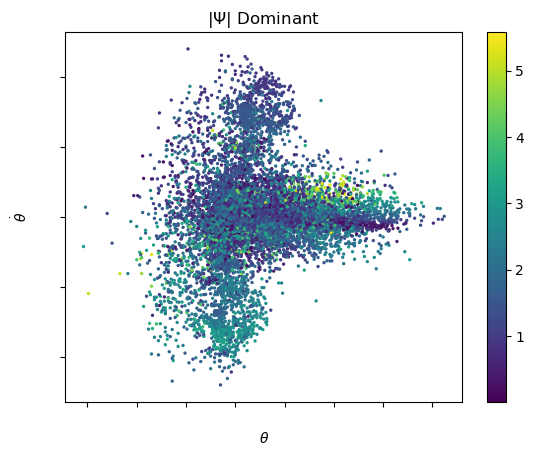

In [52]:
#cm = mcol.LinearSegmentedColormap.from_list("MyCmapName",["w","b"])
normalize = mpl.colors.Normalize(vmin=np.min(Psi_mag[15,:]), vmax=np.max(Psi_mag[0,:]), clip=True)
#normalize = mpl.colors.Normalize(vmin=-1, vmax=1)
P0 = plt.scatter(X[0:,0], X[0:,1], c=Psi_mag[15,0:].numpy(),norm=None, s=2)
plt.colorbar(P0)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\dot\theta$")
# Turn off tick labels
plt.xticks(color='w')
plt.yticks(color='w')
title = '$|\Psi|$ Dominant'
plt.title(title)
plt.savefig(saveTestOutputPath+'phaseP_eigMag'+'.png', dpi=300)
#plt.close()

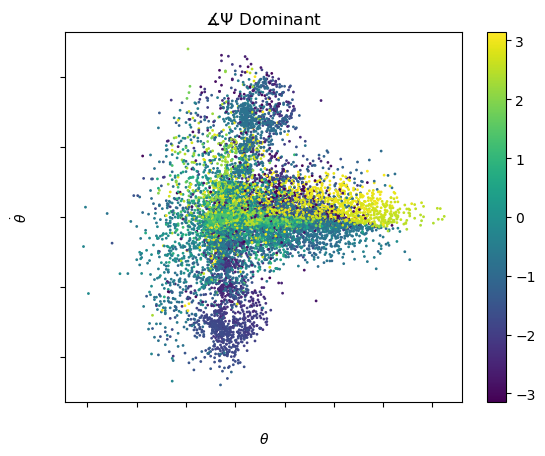

In [53]:
#normalize = mpl.colors.Normalize(vmin=np.min(Psi_mag[0,:]), vmax=np.max(Psi_mag[:,0]))

P0 = plt.scatter(X[:,0], X[:,1], c=Psi_ang[15,:].numpy(), s=1)
plt.colorbar(P0)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\dot\theta$")
# Turn off tick labels
plt.xticks(color='w')
plt.yticks(color='w')
title = '$\measuredangle\Psi$ Dominant'
plt.title(title)
plt.savefig(saveTestOutputPath+'phaseP_eigAngle'+'.png', dpi=300)

# Animation on Test

Animation of Trajectory on Test Data

In [54]:
# Increase framerate
animateStates(doggoFrame.values[:numTraj*trajLength,:], doggoFrame.values[:numTraj*trajLength,:], 'State Trajectory', 'State Trajectory', 
                desiredStates, 'state_trajectory_2', ifGTruthLine=False, xlim=[0,390], ylim=[-2, -1], numFrames=450)

Animation on Koopman output

KeyboardInterrupt: 

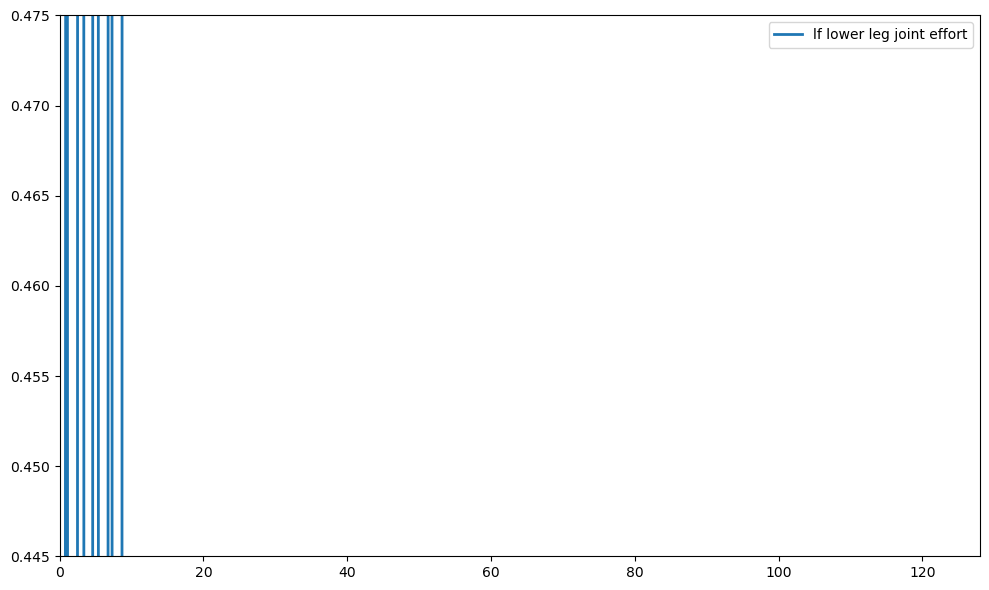

In [55]:
avgTrajErrorList, errorList = avgTrajError(nx1_all, nout1_all, trajLength, numTraj_val)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

animateStatesError(avgTrajErrorArray, errorStdDevArray, desiredStates, 'test_recon_error', mp4FilePath, ifBoundLine=False, ylim=[0.445,0.475])

avgTrajErrorList, errorList = avgTrajError(nx2_all, nout2_all, trajLength-1, numTraj_val)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

animateStatesError(avgTrajErrorArray, errorStdDevArray, desiredStates, 'test_fTimeShiftPred_error', mp4FilePath, ifBoundLine=False, ylim=[0.445,0.475])

avgTrajErrorList, errorList = avgTrajError(nx3_all, nout3_all, trajLength-1, numTraj_val)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

animateStatesError(avgTrajErrorArray, errorStdDevArray, desiredStates, 'test_linPred_error', mp4FilePath, ifBoundLine=False, ylim=[0.445,0.475])

Trajectory

In [ ]:
animateStates(nout1_all,nx1_all,'Reconstruction','Truth',  desiredStates, 'test_traj_recon',xlim=[0,256])
animateStates(nout2_all,nx2_all,'Forward Time Shift','Truth', desiredStates, 'test_traj_FTimeShiftPred',xlim=[0,256])
animateStates(nout3_all,nx3_all,'Lin Pred','Truth', desiredStates, 'test_traj_linPred', xlim=[0,256])